
# Homework 1: Eigenflowers (PCA on Images)

This notebook walks through an **end-to-end PCA pipeline** on a non-face image dataset (e.g., **Oxford 102 Flowers**).  
You will:
- Preprocess images (grayscale, resize, flatten)
- Build the data matrix `A` (pixels × samples)
- Compute PCA via **dual trick** (`L = AᵀA / M`) **or** via **thin SVD**
- Visualize the **mean image** and **top eigenimages** ("eigenflowers")
- Reconstruct images using the top-k components and evaluate error

> **For homework 1:** This notebook is commented and includes **TODO** markers.  
> Please add your implementation where the **TODO** markers are, including code and Markdown cells.



## 0) Environment & Imports

We will use the standard scientific Python packages (`numpy`, `PIL`, `matplotlib`) along with `hashlib`.   
Note that each student should have their own unique seed for repeatability.   
Make sure your kernel uses Python ≥ 3.8.


In [120]:
# Imports
import os
import numpy as np
import hashlib
from PIL import Image
import matplotlib.pyplot as plt

# Set a fixed random seed (given for each student) for reproducibility
# **TODO** set your own fixed token with the ***last 4 digits of your UB person number***
# Reproducibility via TOKEN
TOKEN = "1896"  # unique token per student
SEED = int(hashlib.sha256(TOKEN.encode()).hexdigest(), 16) % (10**6)
print("SEED:", SEED)

# Matplotlib defaults (no specific colors)
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["axes.grid"] = True


SEED: 27041



## 1) Point to your dataset

- Download and extract **Flowers dataset** (from the given image folder) locally.
- Set `DATA_DIR` to the folder containing the training images.
- Choose a target size (e.g., **64×64**) and an optional cap on images for quick experiments.


In [121]:

# === YOUR INPUTS ===
DATA_DIR = "dataset/train"   # <-- TODO: set this to your local training data path
OUTPUT_SIZE = (64, 64)         # TODO: you can try (32, 32) for speed
MAX_IMAGES = 100               # TODO: set an int (e.g., 10) to cap for quick tests



## 2) Preprocessing helpers

We have small utilities for you to:
- Walk the dataset directory
- Convert to **grayscale**
- **Resize** to the same size
- **Flatten** to vectors and **normalize** to `[0,1]`
- Stack as columns into the data matrix **A** of shape `(pixels, M)`


In [122]:

def load_and_preprocess(data_dir, size=(64, 64), max_images=None):
    '''
    Load images recursively from 'data_dir'.
    Convert to grayscale, resize to 'size', flatten, normalize to [0,1].
    Returns:
      A: np.ndarray shape (pixels, M)  -- data matrix (columns are images)
      paths: list[str]                 -- list of file paths used (length M)
    '''
    vectors = []
    paths = []
    for root, _, files in os.walk(data_dir):
        for fn in files:
            if fn.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')):
                path = os.path.join(root, fn)
                try:
                    img = Image.open(path).convert('L').resize(size)  # grayscale + resize
                    vec = np.asarray(img, dtype=np.float32).flatten() / 255.0
                    vectors.append(vec)
                    paths.append(path)
                    if max_images is not None and len(vectors) >= max_images:
                        break
                except Exception as e:
                    print(f"[warn] Skipping {path}: {e}")
        if max_images is not None and len(vectors) >= max_images:
            break

    if not vectors:
        raise RuntimeError("No images found. Check your DATA_DIR and file extensions.")

    A = np.column_stack(vectors)  # shape: (pixels, M)
    return A, paths

# Quick test on function signature (no execution yet).
print("Helper 'load_and_preprocess' defined.")


Helper 'load_and_preprocess' defined.



## 3) Load & preprocess images

You may want to use only a small number of images and make them small (32x32) while coding and debugging


In [123]:

# TODO: Uncomment to run when DATA_DIR is set correctly.
A, paths = load_and_preprocess(DATA_DIR, size=OUTPUT_SIZE, max_images=MAX_IMAGES)
print("A.shape (pixels x M):", A.shape)
print("Example paths (first 3):", paths[:3])


A.shape (pixels x M): (4096, 30)
Example paths (first 3): ['dataset/train/image_05106.jpg', 'dataset/train/image_05113.jpg', 'dataset/train/image_07089.jpg']



## 4) TODO: Mean image & centering

PCA expects **mean-centered** data.  
- Compute the **mean image** across columns of `A`  
- Subtract it from each column to get `A_centered`


mean_image shape: (4096, 1)
A_centered shape: (4096, 30)
first 5 dims of column means: [-0. -0.  0. -0. -0.]


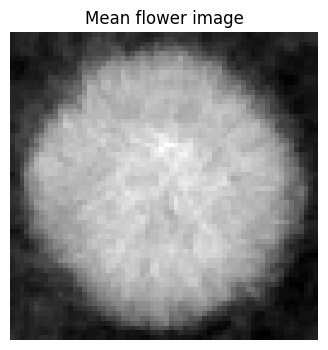

In [124]:

# TODO: Compute the mean image and obtain `A_centered` from the `A` built in the cell above
# Then plot your mean image to ensure it looks like a flower... somewhat...


# Mean image & centering
# A is (pixels × M): each column is one flattened, normalized image.

mean_image = A.mean(axis=1, keepdims=True)     # (pixels, 1)
A_centered = A - mean_image                    # subtract the mean from every column

# quick sanity checks
print(f"mean_image shape: {mean_image.shape}")   
print(f"A_centered shape: {A_centered.shape}")   

col_means_sample = np.mean(A_centered, axis=1)[:5]
print("first 5 dims of column means:", np.round(col_means_sample, 6))

# visualize the mean image
plt.imshow(mean_image.reshape(OUTPUT_SIZE[1], OUTPUT_SIZE[0]), cmap="gray")
plt.title("Mean flower image")
plt.axis("off")
plt.show()


## 5) TODO: Implement PCA (Method 1): Thin SVD

Compute SVD of `A_centered` directly: 
You can use the `SVD` function from the `linalg` library in numpy
> $A_{\text{centered}} = U \Sigma V^\top$

- Covariance eigenvalues: $\lambda_i = \frac{1}{M}\sigma_i^2$  
- Eigenimages (eigenvectors) are the columns of $U$

> **This metod is often numerically preferred as it is more stable**

In [125]:

def pca_svd(A_centered, num_components=None):
    '''
    PCA via thin SVD.
    Returns:
      U_k: eigenimages (pixels x k), orthonormal columns
      eigvals_k: covariance eigenvalues (length k), sorted desc
    '''
    # Thin SVD: 
    U, S, Vt = np.linalg.svd(A_centered, full_matrices=False)
    
    # Covariance eigenvalues: 
    M = A_centered.shape[1]
    eigvals = (S**2) / M
    
    # Keeping top-k 
    if num_components is not None:
        U = U[:, :num_components]
        eigvals = eigvals[:num_components]
    
    return U, eigvals

print("Helper 'pca_svd' defined.")


Helper 'pca_svd' defined.


In [126]:
U1, eigvals1 = pca_svd(A_centered, num_components=None)
print("U1.shape:", U1.shape)                 
print("eigvals1.shape:", eigvals1.shape)    
print("eigvals1 nonneg? min=", eigvals1.min())
print("orthonormal? ||U^T U - I||_F =", np.linalg.norm(U1.T @ U1 - np.eye(U1.shape[1])))

U1.shape: (4096, 30)
eigvals1.shape: (30,)
eigvals1 nonneg? min= 5.7287686e-12
orthonormal? ||U^T U - I||_F = 4.046913469539389e-06


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/200341351.py:5: RuntimeWarning: divide by zero encountered in matmul
  print("orthonormal? ||U^T U - I||_F =", np.linalg.norm(U1.T @ U1 - np.eye(U1.shape[1])))
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/200341351.py:5: RuntimeWarning: overflow encountered in matmul
  print("orthonormal? ||U^T U - I||_F =", np.linalg.norm(U1.T @ U1 - np.eye(U1.shape[1])))
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/200341351.py:5: RuntimeWarning: invalid value encountered in matmul
  print("orthonormal? ||U^T U - I||_F =", np.linalg.norm(U1.T @ U1 - np.eye(U1.shape[1])))



## 6) TODO: PCA (Method 2a): Dual trick

Compute eigenpairs of the small **sample–sample** $L$ matrix given $A_{\text{centered}}$:

$L = \frac{1}{M} A^\top A \in \mathcal{R}^{M \times M}$,

- Solve $L v_i = \lambda_i v_i$; You can use the prebuilt linear algebra $\texttt{eigvals, V = np.linalg.eigh}$ function call
- This will return the eigen values and vectors in $\textbf{ascending}$ order; you want to reverse this order
- Now map this back into the feature space: $u_i = A_{\text{centered}}\; v_i$
- Normalize each $u_i$ to unit length

In [127]:

def pca_dual(A_centered, num_components=None):
    '''
    PCA via dual trick: eigendecompose L = (A^T A)/M, then map back to feature space.
    Returns:
      U: eigenimages as columns (pixels x k), unit-norm
      eigvals: covariance eigenvalues (length k), sorted desc
    '''
    # 1) small sample matrix
    M = A_centered.shape[1]
    L = (A_centered.T @ A_centered) / M            # (M x M), symmetric

    # 2) eigendecompose (ascending), then reverse to descending
    eigvals, V = np.linalg.eigh(L)                  
    idx = np.argsort(eigvals)[::-1]                
    eigvals = eigvals[idx]
    V = V[:, idx]

    # 3) keeping top-k 
    if num_components is not None:
        V = V[:, :num_components]
        eigvals = eigvals[:num_components]

    # 4) map to pixel space 
    U = A_centered @ V                             
    U /= (np.linalg.norm(U, axis=0, keepdims=True) + 1e-12)

    return U, eigvals

print("Helper 'pca_dual' defined.")


Helper 'pca_dual' defined.


In [128]:
U2, eigvals2 = pca_dual(A_centered, num_components=None)
print("U2.shape:", U2.shape)
print("eigvals2.shape:", eigvals2.shape)

# Compare with SVD results 
print("eigvals close? ", np.allclose(eigvals2, eigvals1, rtol=1e-4, atol=1e-7))

# Cosine similarity of first few eigenimages 
k_check = min(10, U1.shape[1], U2.shape[1])
cos = np.abs(np.sum(U1[:, :k_check] * U2[:, :k_check], axis=0))
print("cosine similarity (first k):", np.round(cos, 4))

U2.shape: (4096, 30)
eigvals2.shape: (30,)
eigvals close?  False
cosine similarity (first k): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:10: RuntimeWarning: divide by zero encountered in matmul
  L = (A_centered.T @ A_centered) / M            # (M x M), symmetric
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:10: RuntimeWarning: overflow encountered in matmul
  L = (A_centered.T @ A_centered) / M            # (M x M), symmetric
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:10: RuntimeWarning: invalid value encountered in matmul
  L = (A_centered.T @ A_centered) / M            # (M x M), symmetric
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:24: RuntimeWarning: divide by zero encountered in matmul
  U = A_centered @ V
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:24: RuntimeWarning: overflow encountered in matmul
  U = A_centered @ V
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:24

## 7) TODO: PCA (Method 2b): Dual trick + Eigendecomposition using the Power Method

Again we want to compute eigenpairs of the $L$ matrix, but this time we will use the **power method**:

- We again want to solve $L v_i = \lambda_i v_i$
- We will implement our own version of the power method
>   We will write 2 auxilliary functions to aid with this
- Like before, the power method will return the eigen values and vectors, but in descending order
- Now map this back into the feature space: $u_i = A_{\text{centered}}\; v_i$
- Normalize each $u_i$ to unit length

### Aux 1) TODO: The Power Method for the most dominant eigenpair (single)   
$\textbf{GOAL:}$ Approximate the dominant eigenvalue $\lambda_{\max}$ and corresponding eigenvector $v_{\max}$ of a matrix $L \in \mathbb{R}^{m \times m}$.

PSEUDOCODE FOR POWER METHOD:
1. Create a random vector $x_0$ of length $\texttt{L.shape[0]}$  
   - Normalize the vector via $\frac{x_0}{\|x_0\|}$  
   - Set $\lambda_0 = 0.0$ <br>

2. For $k = 1, 2, \dots, \texttt{num\_iter}$
    - Multiply: $y_k = L x_{k-1}$ 
    - Normalize: $x_k = \tfrac{y_k}{\|y_k\|}$
    - Rayleigh quotient: $\lambda_k = x_k^\top L x_k$
    - if $|\lambda_k - \lambda_{k-1}| \le \epsilon$; BREAK   

3. Output $(\lambda_k, x_k)$ as approximation of the dominant eigenpair.

$\textbf{Note:}$ these are all matrix multiplications - use the operator "@"


In [129]:
def power_method_sym(L, num_iters=200, tol=1e-12, x0=None):
    '''
    power_method_sym takes a symmetric matrix L, the number of iterations and a tolerance value.
    Returns:
      lam: the dominant eigenvalue of L
      x:  the corresponding unit-norm eigenvector
    '''
    n = L.shape[0]
    # init vector
    if x0 is None:
        rng = np.random.default_rng(12345)
        x = rng.normal(size=n).astype(float)
    else:
        x = np.array(x0, dtype=float, copy=True)
    # normalize
    x /= (np.linalg.norm(x) + 1e-12)

    lam_prev = 0.0
    for _ in range(num_iters):
        y = L @ x
        ny = np.linalg.norm(y)
        if ny < 1e-14:                 # zero vector case
            break
        x = y / ny            
        lam = float(x @ (L @ x))       # Rayleigh quotient
        if abs(lam - lam_prev) <= tol * max(1.0, abs(lam_prev)):
            break
        lam_prev = lam

    # final values
    lam = float(x @ (L @ x))
    x  = x / (np.linalg.norm(x) + 1e-12)
    return lam, x

In [130]:

M = A_centered.shape[1]
L = (A_centered.T @ A_centered) / M

lam_pm, v_pm = power_method_sym(L, num_iters=1000, tol=1e-10)

evals, V = np.linalg.eigh(L)     
lam_true = evals[-1]
cos = abs(np.dot(v_pm, V[:, -1])) 

print("power λ:", lam_pm, "| true λ:", lam_true)
print("cosine |v_pm, v_true|:", cos)

power λ: 27.239215917005453 | true λ: 27.239216
cosine |v_pm, v_true|: 1.0000000065309385


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/4195627765.py:2: RuntimeWarning: divide by zero encountered in matmul
  L = (A_centered.T @ A_centered) / M
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/4195627765.py:2: RuntimeWarning: overflow encountered in matmul
  L = (A_centered.T @ A_centered) / M
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/4195627765.py:2: RuntimeWarning: invalid value encountered in matmul
  L = (A_centered.T @ A_centered) / M


### Aux 2) TODO: The Power Method to compute the top-k eigenpairs of L (symmetrical)

$k = \min(k, m)$; where $m$ is $\texttt{L.shape[0]}$  

For $i = 1, 2, \dots, k$   
   - call $\lambda_k, v_k =$ power_method_sym$(L)$
   - next perform a $\textbf{rank-1 deflation}$ of $L$:
      - set $L \leftarrow L - \lambda_k v_k v_k^\top$
      - repeat the power method on deflations of $L$ to get the remaining eigenpairs in a descending order of $\lambda$'s


In [131]:
def power_method_sym_allk(L, k=None, num_iters=200, tol=1e-8, sort_by_abs=True):
    """
    Compute the top-k eigenpairs of a symmetric matrix L using power iteration with deflation.
    """
    Lw = L.astype(float).copy()   # work on a copy
    m = Lw.shape[0]
    k = m if k is None else min(k, m)

    lambdas, vecs = [], []
    rng = np.random.default_rng(12345)

    for _ in range(k):
        # dominant pair on current deflated matrix
        x0 = rng.normal(size=m)
        lam, v = power_method_sym(Lw, num_iters=num_iters, tol=tol, x0=x0)

        # re-orthogonalize to previous vectors
        for u in vecs:
            v -= (u @ v) * u
        v /= (np.linalg.norm(v) + 1e-12)
        lam = float(v @ (Lw @ v))  # refresh 

        lambdas.append(lam)
        vecs.append(v)

        # remove the found component
        Lw -= lam * np.outer(v, v)

    lambdas = np.array(lambdas)
    V = np.stack(vecs, axis=1) if vecs else np.zeros((m, 0))

    # sort largest to smallest 
    order = np.argsort(np.abs(lambdas) if sort_by_abs else lambdas)[::-1]
    return lambdas[order], V[:, order]

In [132]:
M = A_centered.shape[1]
L = (A_centered.T @ A_centered) / M

k = min(10, M)
lam_k, V_k = power_method_sym_allk(L, k=k, num_iters=600, tol=1e-10)

# compare against numpy eigh 
evals_full, V_full = np.linalg.eigh(L)
evals_true = evals_full[::-1][:k]
V_true = V_full[:, ::-1][:, :k]

print("lambda (power)  :", np.round(lam_k[:5], 6))
print("lambda (np.eigh):", np.round(evals_true[:5], 6))

# cosine similarity per eigenvector 
cos = np.abs(np.sum(V_k * V_true, axis=0))
print("cosine |v_power, v_true| (first k):", np.round(cos, 4))

lambda (power)  : [27.239216 21.245809 17.235513  9.257201  7.517478]
lambda (np.eigh): [27.239216 21.24581  17.235514  9.2572    7.517478]
cosine |v_power, v_true| (first k): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2385762379.py:2: RuntimeWarning: divide by zero encountered in matmul
  L = (A_centered.T @ A_centered) / M
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2385762379.py:2: RuntimeWarning: overflow encountered in matmul
  L = (A_centered.T @ A_centered) / M
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2385762379.py:2: RuntimeWarning: invalid value encountered in matmul
  L = (A_centered.T @ A_centered) / M


### TODO: Now implement pca_dualpower 

Use the the same signature as the other PCA calls; use your auxilliary methods and have the same return values

In [133]:
def pca_dualpower(A_centered, num_components=None):
    '''
    PCA via dual trick: using your own handwritten Power Method
    Returns:
      U: eigenimages as columns (pixels x k), unit-norm
      eigvals: covariance eigenvalues (length k), sorted desc
    '''
    M = A_centered.shape[1]
    # sample matrix (symmetric)
    L = (A_centered.T @ A_centered) / M

    # how many components?
    k = M if num_components is None else min(num_components, M)

    # get top-k eigenpairs via power iteration + deflation
    eigvals, V = power_method_sym_allk(L, k=k, num_iters=600, tol=1e-10, sort_by_abs=True)

    # map back to pixel space and normalize columns
    U = A_centered @ V
    U /= (np.linalg.norm(U, axis=0, keepdims=True) + 1e-12)

    return U, eigvals

print("Helper 'pca_dualpower' defined.")

Helper 'pca_dualpower' defined.


In [134]:
U3, eigvals3 = pca_dualpower(A_centered, num_components=None)
print("U3.shape:", U3.shape, "| eigvals3.shape:", eigvals3.shape)

# compare eigenvalues vs dual/eigh or SVD 
print("eigvals match SVD? ",
      np.allclose(eigvals3[:min(len(eigvals3), len(eigvals1))],
                  eigvals1[:min(len(eigvals3), len(eigvals1))],
                  rtol=1e-4, atol=1e-7))

# cosine similarity of first few eigenimages 
k_check = min(10, U1.shape[1], U3.shape[1])
cos = np.abs(np.sum(U1[:, :k_check] * U3[:, :k_check], axis=0))
print("cosine(U_svd, U_power) first k:", np.round(cos, 4))

U3.shape: (4096, 30) | eigvals3.shape: (30,)
eigvals match SVD?  False
cosine(U_svd, U_power) first k: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2899515420.py:10: RuntimeWarning: divide by zero encountered in matmul
  L = (A_centered.T @ A_centered) / M
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2899515420.py:10: RuntimeWarning: overflow encountered in matmul
  L = (A_centered.T @ A_centered) / M
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2899515420.py:10: RuntimeWarning: invalid value encountered in matmul
  L = (A_centered.T @ A_centered) / M
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2899515420.py:19: RuntimeWarning: divide by zero encountered in matmul
  U = A_centered @ V
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2899515420.py:19: RuntimeWarning: overflow encountered in matmul
  U = A_centered @ V
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/2899515420.py:19: RuntimeWarning: invalid value encountered in matmul
  U = A_centered @ V


### 8) TODO: Compute your eigenflowers using each of the 3 PCA methods (1:thin SVD, 2:dual method, 3:dual with power method)


In [135]:

# TODO: Uncomment and run after you have defined the processes above
U1, eigvals1 = pca_svd(A_centered, num_components=None)
print("U1.shape (pixels x k):", U1.shape)
print("eigvals1.shape:", eigvals1.shape)

U2, eigvals2 = pca_dual(A_centered, num_components=None)
print("U2.shape (pixels x k):", U2.shape)
print("eigvals2.shape:", eigvals2.shape)

U3, eigvals3 = pca_dualpower(A_centered, num_components=None)
print("U3.shape (pixels x k):", U3.shape)
print("eigvals3.shape:", eigvals3.shape)


U1.shape (pixels x k): (4096, 30)
eigvals1.shape: (30,)
U2.shape (pixels x k): (4096, 30)
eigvals2.shape: (30,)
U3.shape (pixels x k): (4096, 30)
eigvals3.shape: (30,)


/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:10: RuntimeWarning: divide by zero encountered in matmul
  L = (A_centered.T @ A_centered) / M            # (M x M), symmetric
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:10: RuntimeWarning: overflow encountered in matmul
  L = (A_centered.T @ A_centered) / M            # (M x M), symmetric
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:10: RuntimeWarning: invalid value encountered in matmul
  L = (A_centered.T @ A_centered) / M            # (M x M), symmetric
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:24: RuntimeWarning: divide by zero encountered in matmul
  U = A_centered @ V
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:24: RuntimeWarning: overflow encountered in matmul
  U = A_centered @ V
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3482943640.py:24


## 9) Visualize the top eigenflowers


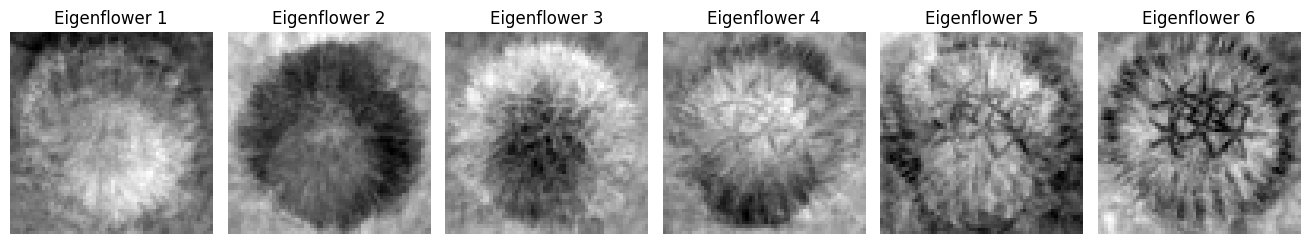

In [136]:

def show_eigenimages(U, size, k=6, title_prefix="Eigenimage"):
    k = min(k, U.shape[1])
    if k <= 0:
        print("[warn] No eigenimages to display.")
        return
    fig, axes = plt.subplots(1, k, figsize=(2.2*k, 2.8))
    if k == 1:
        axes = [axes]
    for i in range(k):
        axes[i].imshow(U[:, i].reshape(size[::-1]), cmap="gray")
        axes[i].set_title(f"{title_prefix} {i+1}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Run after U1, U2, U3 are available
show_eigenimages(U3, OUTPUT_SIZE, k=6, title_prefix="Eigenflower")


## 10) TODO: Reconstruction with top-k components

Pick one image, project onto top-k eigenimages, and reconstruct.  
Display your reconstructions  
Observe how reconstruction improves as k increases.


**Reconstruction with top-k components**

Here I pick one image and reconstruct it using the first k eigenflowers.  
As k increases, the reconstruction gets sharper and closer to the original, and the mean-squared error decreases.  
The error curve shows that most of the structure is captured in the first few components.

/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/10375156.py:10: RuntimeWarning: divide by zero encountered in matmul
  recon_x = mean_image.squeeze() + Uk @ coeffs
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/10375156.py:10: RuntimeWarning: overflow encountered in matmul
  recon_x = mean_image.squeeze() + Uk @ coeffs
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/10375156.py:10: RuntimeWarning: invalid value encountered in matmul
  recon_x = mean_image.squeeze() + Uk @ coeffs
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/10375156.py:9: RuntimeWarning: divide by zero encountered in matmul
  coeffs = Uk.T @ x_centered        # (k,)
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/10375156.py:9: RuntimeWarning: overflow encountered in matmul
  coeffs = Uk.T @ x_centered        # (k,)
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/10375156.py:9: RuntimeWarning: invalid value encounte

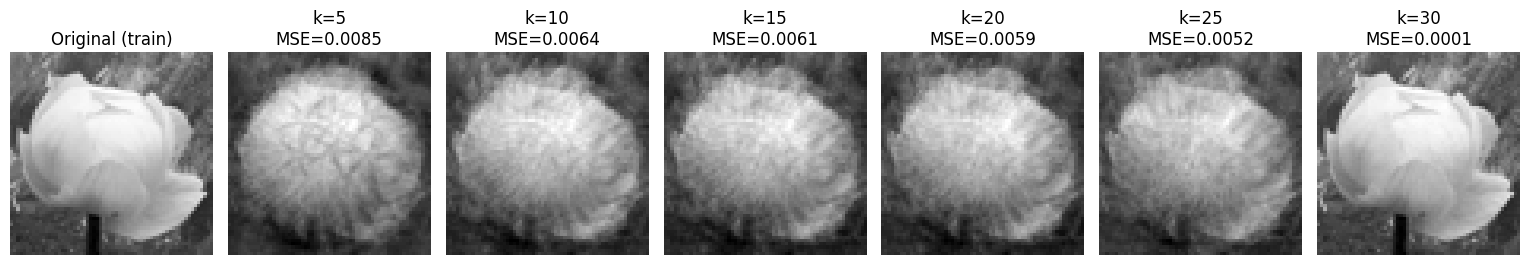

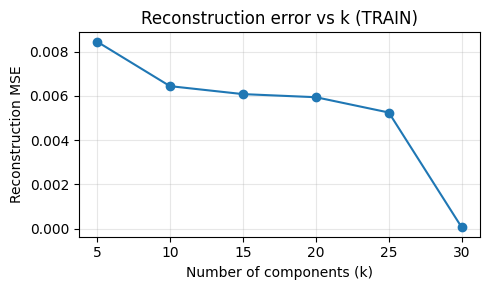

In [ ]:
# 10) Reconstruction with top-k components 

def reconstruct_with_k(U, mean_image, x_centered, k):
    '''
    Reconstruct a single image vector from its centered form using top-k columns of U.
    '''
    k = min(k, U.shape[1])
    Uk = U[:, :k]
    coeffs = Uk.T @ x_centered        # (k,)
    recon_x = mean_image.squeeze() + Uk @ coeffs
    return recon_x


U_basis = U3                 # or U1 (SVD) / U2 (dual)
RUN_MODE = "train"           # "train" or "test"

requested_j = 11            
ks = [5, 10, 15, 20, 25, 30] 

# Select data according to RUN_MODE 
if RUN_MODE == "train":
    M_train = A.shape[1]
    if M_train == 0:
        raise ValueError("A has 0 images. Load data first.")
    j = min(requested_j, M_train - 1)    
    orig = A[:, j].ravel()
    x    = A_centered[:, j].ravel()

elif RUN_MODE == "test":
    try:
        B, _ = load_and_preprocess(TEST_DIR, size=OUTPUT_SIZE, max_images=MAX_IMAGES)
    except NameError as e:
        raise NameError("TEST_DIR is not defined. Set TEST_DIR earlier in the notebook.") from e
    if B.shape[1] == 0:
        raise ValueError("No test images loaded from TEST_DIR.")
    B_centered = B - mean_image[:, None]  
    j = min(requested_j, B.shape[1] - 1)   
    orig = B[:, j].ravel()
    x    = B_centered[:, j].ravel()
else:
    raise ValueError("RUN_MODE must be 'train' or 'test'.")


max_k = U_basis.shape[1]
ks = sorted(set(min(k, max_k) for k in ks))  

# Reconstructions & MSEs 
recons_x = []
mses = []
for k in ks:
    r = reconstruct_with_k(U_basis, mean_image, x, k)
    recons_x.append(r)
    mses.append(float(np.mean((orig - r)**2)))

# Plot original + reconstructions 
cols = len(ks) + 1
plt.figure(figsize=(2.2*cols, 2.8))
ax = plt.subplot(1, cols, 1)
ax.imshow(orig.reshape(OUTPUT_SIZE[::-1]), cmap="gray")
ax.set_title(f"Original ({RUN_MODE})")
ax.axis("off")
for i, (kval, r, mse) in enumerate(zip(ks, recons_x, mses), start=2):
    ax = plt.subplot(1, cols, i)
    ax.imshow(r.reshape(OUTPUT_SIZE[::-1]), cmap="gray")
    ax.set_title(f"k={kval}\nMSE={mse:.4f}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Error curve
plt.figure(figsize=(5,3))
plt.plot(ks, mses, marker="o")
plt.xlabel("Number of components (k)")
plt.ylabel("Reconstruction MSE")
plt.title(f"Reconstruction error vs k ({RUN_MODE.upper()})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 11) TODO: Explained variance; plot the cummulative explained variance   

Plot how much variation is captured by the first k components.   

$EVR_k = \frac{\lambda_k}{\sum_{i=1}^p \lambda_i}$

Cummulative $EVR_m = \frac{\sum_{k=1}^m \lambda_k}{\sum_{i=1}^p \lambda_i}$

Plot $EVR_m$ at every $m$


Cumulative EVR[-1] ≈ 1.000000 (should be ~1.0)
k for 90% variance: 19
k for 95% variance: 23


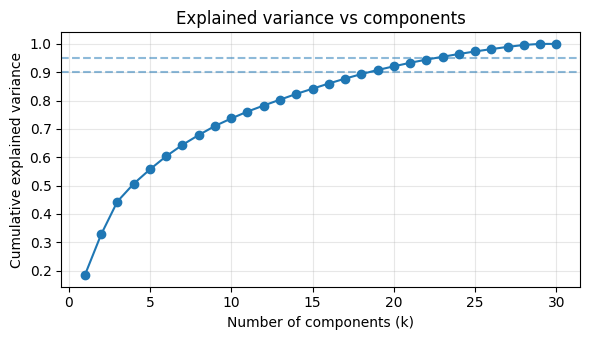

In [ ]:
# 11) Explained variance; cumulative EVR 


try:
    eigvals_ref = eigvals1
except NameError:
    try:
        eigvals_ref = eigvals2
    except NameError:
        eigvals_ref = eigvals3

eigvals_ref = np.asarray(eigvals_ref, dtype=float)

# EVR and cumulative EVR
evr   = eigvals_ref / (eigvals_ref.sum() + 1e-12)
cummu = np.cumsum(evr)

# Quick report of thresholds
k90 = int(np.searchsorted(cummu, 0.90) + 1)
k95 = int(np.searchsorted(cummu, 0.95) + 1)
print(f"Cumulative EVR[-1] ≈ {cummu[-1]:.6f} (should be ~1.0)")
print(f"k for 90% variance: {k90}")
print(f"k for 95% variance: {k95}")

# Plot cumulative EVR
plt.figure(figsize=(6,3.5))
plt.plot(np.arange(1, len(cummu)+1), cummu, marker='o')
plt.axhline(0.90, ls='--', alpha=0.5)
plt.axhline(0.95, ls='--', alpha=0.5)
plt.xlabel("Number of components (k)")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs components")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 12) TODO: Feature Mapping
- Explain how this approach can be used for feature extraction - you can explain that here...

- What exactly are the features and how do we obtain them here?

### Feature Mapping (PCA as Feature Extraction)

In PCA, the **features** are the projection coefficients of each centered image vector onto the top-k principal components (the “eigenflowers”).

Concretely:
- Each image \(x \in \mathbb{R}^p\) is first mean-centered: \(\tilde{x} = x - \mu\).
- We then project onto the eigenbasis \(U_k\):  
  \[
  w = U_k^\top \tilde{x}
  \]
- The resulting vector \(w \in \mathbb{R}^k\) is the **feature representation** of the image.

These features are:
- **Low-dimensional** (k ≪ p), reducing storage and computation.
- **Variance-preserving**, capturing the directions of maximum information in the data.
- **Decorrelated**, since PCA produces orthogonal components.

So instead of working directly with thousands of pixel intensities, we can represent each flower image compactly with its k PCA coefficients, which can then be used for downstream tasks like classification, clustering, or visualization.

### Common Exponential-Family Distributions

**1) Gaussian (Normal)**  
- PDF: f(x) = (1 / √(2πσ²)) * exp( - (x - μ)² / (2σ²) )  
- Parameters: μ (mean), σ² (variance)  
- Type: continuous  
- Use: real-valued data with symmetric variation around a mean  

---

**2) Bernoulli**  
- PMF: P(X=1) = p ,  P(X=0) = 1 - p  
- Parameter: p (probability of success)  
- Type: discrete  
- Use: one trial, success/failure outcome  

---

**3) Binomial**  
- PMF: P(X = k) = C(n, k) * p^k * (1 - p)^(n - k)  
- Parameters: n (number of trials), p (success probability)  
- Type: discrete  
- Use: number of successes in n independent trials  

---

**4) Multinomial**  
- PMF: P(x₁,...,xₖ) = n! / (x₁!…xₖ!) * p₁^x₁ * … * pₖ^xₖ  
- Parameters: n (number of trials), p₁…pₖ (category probabilities)  
- Type: discrete  
- Use: counts across multiple categories  

---

**5) Exponential**  
- PDF: f(x) = λ * exp(-λx),  for x ≥ 0  
- Parameter: λ (rate)  
- Type: continuous  
- Use: waiting times between events  

---

**6) Poisson**  
- PMF: P(X = k) = (λ^k * exp(-λ)) / k!  
- Parameter: λ (average rate)  
- Type: discrete  
- Use: count of events in fixed time/space interval  

/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3286609267.py:9: RuntimeWarning: divide by zero encountered in matmul
  W = (U1[:, :k_tsne].T @ A_centered).T
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3286609267.py:9: RuntimeWarning: overflow encountered in matmul
  W = (U1[:, :k_tsne].T @ A_centered).T
/var/folders/dl/l6fmhp8100j2dpv_w0jnk95r0000gn/T/ipykernel_57101/3286609267.py:9: RuntimeWarning: invalid value encountered in matmul
  W = (U1[:, :k_tsne].T @ A_centered).T


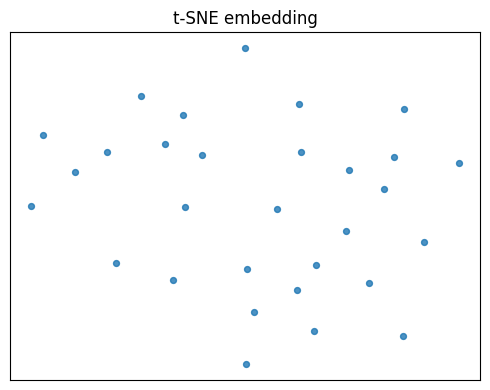

In [ ]:
# Bonus: t-SNE on raw pixels or PCA features
from sklearn.manifold import TSNE


Z = A.T


k_tsne = min(20, U1.shape[1])
W = (U1[:, :k_tsne].T @ A_centered).T   
Z = W 

tsne = TSNE(n_components=2, perplexity=8, random_state=SEED, init="random", learning_rate="auto")
Y = tsne.fit_transform(Z)

plt.figure(figsize=(5,4))
plt.scatter(Y[:,0], Y[:,1], s=18, alpha=0.8)
plt.title("t-SNE embedding")
plt.xticks([]); plt.yticks([])
plt.tight_layout(); plt.show()